# KAN Visuals custom

## Imports + pip

In [44]:
from kan import KAN
from kan import MultKAN
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import yaml
import os
from torchvision import transforms
from kan.spline import B_batch
import numpy as np
from sympy.printing import latex
from sympy import *
import sympy

In [45]:
os.makedirs('/pictures', exist_ok=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


## Data transform

In [46]:
# read train and test data
train = pd.read_csv('../data/MNIST/mnist_train.csv')
test = pd.read_csv('../data/MNIST/mnist_test.csv')
# convert data to numpy arrays
x_train = train.drop('label', axis=1).values
x_test = test.drop('label', axis=1).values
y_train = train['label'].values
y_test = test['label'].values

# set target size to scale images
target_size = 8

# define transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((target_size, target_size)),
    transforms.ToTensor()
])

# transform the data
def transform_images(images):
    transformed_images = []
    for image in images:
        image = image.reshape(28, 28).astype(np.uint8)
        image = transform(image)
        image = image.view(-1)
        transformed_images.append(image)
    return torch.stack(transformed_images)

train_input = transform_images(x_train)
test_input = transform_images(x_test)
train_label = torch.tensor(y_train, dtype=torch.int64)
test_label = torch.tensor(y_test, dtype=torch.int64)

dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Convert labels to Long tensors
dataset['train_label'] = dataset['train_label'].long()
dataset['test_label'] = dataset['test_label'].long()

dataset['train_input'] = train_input.to(device)
dataset['test_input'] = test_input.to(device)
dataset['train_label'] = train_label.to(device)
dataset['test_label'] = test_label.to(device)

## Loading Model

In [47]:
#Parameter
hidden_1 = 3
hidden_2 = 0
steps = 45
grid = 3
k = 3
seed = 42
input_dim = train_input.shape[ 1 ]   # Anzahl der Eingabefunktionen
output_dim = 10   # Anzahl der Klasse

#Count
if hidden_2>0:
    Parameter = (hidden_1*input_dim+hidden_1*hidden_2+hidden_2*output_dim)*(grid+k)
    print(f"Parameter count = {Parameter}")
else:
    Parameter = hidden_1*(input_dim+output_dim)*(grid+k)
    print(f"Parameter count = {Parameter}")

Parameter count = 1332


In [48]:
model = KAN(width=[input_dim, hidden_1, output_dim], grid= grid , k= k , seed= seed)  # Vereinfachte Modellkonfiguratio5

checkpoint directory created: ./model
saving model version 0.0


In [49]:
model = model.loadckpt("./Modelle/model_mnist_h_3_s_45_g_3_k_3")

Aktuelles Verzeichnis: c:\Users\a829727\OneDrive - Eviden\Dokumente\Uni\Semester 6\AML\KAN-project\KAN-Model


## Funktions

### normal

In [50]:
def adjust_dict_colors(input_dict):
    """
    Passt jedes Value in einem Dictionary an, indem es zwischen blau (0) und rot (1) interpoliert.
    """
    def interpolate_color(value):
        """
        Interpoliert zwischen blau (0) und rot (1).
        """
        assert 0 <= value <= 1, "Value must be between 0 and 1"

        # RGB-Werte
        blue = np.array([0.047058823529411764, 0.5568627450980392, 0.8235294117647058])  # blau
        yellow = np.array([0.7294117647058823, 0.0, 0.12549019607843137])   # gelb

        # Lineare Interpolation
        color = blue * (1 - value) + yellow * value

        return color

    return {k: interpolate_color(v) for k, v in input_dict.items()}

def normalice(x):
    # Berechne den minimalen und maximalen Wert
    x_min = x.min()
    x_max = x.max()

    # Überprüfe, ob min und max gleich sind
    if x_min == x_max:
        x_normalized = torch.zeros_like(x)  # oder eine andere geeignete Konstante
    else:
        # Normalisiere den Tensor zwischen 0 und 1
        x_normalized = (x - x_min) / (x_max - x_min)

    return x_normalized

### custom

#### plot

In [51]:
def plot_cursed(self, folder="./figures", beta=3, mask=False, metric='fa', scale=0.5, tick=False, sample=False, in_vars=None, out_vars=None, title=None, varscale=1.0, plus=0.15, ac_scale=0.4, color_activations=None):
    global Symbol

    if not self.save_act:
        print('cannot plot since data are not saved. Set save_act=True first.')

    # forward to obtain activations
    if self.acts is None:
        if self.cache_data is None:
            raise Exception('model hasn\'t seen any data yet.')
        self.forward(self.cache_data)

    if metric == 'fa':
        self.attribute()

    if not os.path.exists(folder):
        os.makedirs(folder)

    if color_activations is None:
        color_activations = {}

    def get_activation_color(layer, input_idx, output_idx):
        return color_activations.get((layer, input_idx, output_idx), None)

    depth = len(self.width) - 1
    for l in range(depth):
        w_large = 2.0
        for i in range(self.width_in[l]):
            for j in range(self.width_out[l+1]):
                rank = torch.argsort(self.acts[l][:, i])
                fig, ax = plt.subplots(figsize=(w_large, w_large))

                num = rank.shape[0]

                symbolic_mask = self.symbolic_fun[l].mask[j][i]
                numeric_mask = self.act_fun[l].mask[i][j]

                if symbolic_mask > 0. and numeric_mask > 0.:
                    color = 'purple'
                    alpha_mask = 1
                elif symbolic_mask > 0. and numeric_mask == 0.:
                    color = "red"
                    alpha_mask = 1
                elif symbolic_mask == 0. and numeric_mask > 0.:
                    color = "black"
                    alpha_mask = 1
                elif symbolic_mask == 0. and numeric_mask == 0.:
                    color = "white"
                    alpha_mask = 0

                # Custom condition to set specific activation colors
                activation_color = get_activation_color(l, i, j)
                if activation_color is not None:
                    color = activation_color

                if tick:
                    ax.tick_params(axis="y", direction="in", pad=-22, labelsize=50)
                    ax.tick_params(axis="x", direction="in", pad=-15, labelsize=50)
                    x_min, x_max, y_min, y_max = self.get_range(l, i, j, verbose=False)
                    plt.xticks([x_min, x_max], ['%2.f' % x_min, '%2.f' % x_max])
                    plt.yticks([y_min, y_max], ['%2.f' % y_min, '%2.f' % y_max])
                else:
                    plt.xticks([])
                    plt.yticks([])
                if alpha_mask == 1:
                    plt.gca().patch.set_edgecolor((0.047058823529411764, 0.5568627450980392, 0.8235294117647058)) #black
                else:
                    plt.gca().patch.set_edgecolor('white')
                plt.gca().patch.set_linewidth(1.5)

                plt.plot(self.acts[l][:, i][rank].cpu().detach().numpy(), self.spline_postacts[l][:, j, i][rank].cpu().detach().numpy(), color=color, lw=5)
                if sample:
                    plt.scatter(self.acts[l][:, i][rank].cpu().detach().numpy(), self.spline_postacts[l][:, j, i][rank].cpu().detach().numpy(), color=color, s=400 * scale ** 2)
                plt.gca().spines[:].set_color(color)

                plt.savefig(f'{folder}/sp_{l}_{i}_{j}.png', bbox_inches="tight", dpi=400)
                plt.close()

    def score2alpha(score):
        return np.tanh(beta * score)

    if metric == 'act':
        scores = self.acts_scale
    elif metric == 'fa':
        scores = self.edge_scores

    alpha = [score2alpha(score.cpu().detach().numpy()) for score in scores]

    # draw skeleton
    width = np.array(self.width)
    width_in = np.array(self.width_in)
    width_out = np.array(self.width_out)
    A = 1
    y0 = 0.3  # height: from input to pre-mult
    z0 = 0.1  # height: from pre-mult to post-mult (input of next layer)

    neuron_depth = len(width)
    min_spacing = A / np.maximum(np.max(width_out), 5)

    max_neuron = np.max(width_out)
    max_num_weights = np.max(width_in[:-1] * width_out[1:])
    y1 = ac_scale / np.maximum(max_num_weights, 5)  # size (height/width) of 1D function diagrams
    y2 = plus / np.maximum(max_neuron, 5)  # size (height/width) of operations (sum and mult)

    fig, ax = plt.subplots(figsize=(10 * scale, 10 * scale * (neuron_depth - 1) * (y0 + z0)))
    # Set background color for the entire plot
    fig.patch.set_facecolor((0.054901960784313725, 0.06666666666666667, 0.09019607843137255))

    # -- Transformation functions
    DC_to_FC = ax.transData.transform
    FC_to_NFC = fig.transFigure.inverted().transform
    # -- Take data coordinates and transform them to normalized figure coordinates
    DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

    # plot scatters and lines
    for l in range(neuron_depth):

        n = width_in[l]

        # scatters
        for i in range(n):
            plt.scatter(1 / (2 * n) + i / n, l * (y0 + z0), s=min_spacing ** 2 * 10000 * scale ** 2, color=(0.047058823529411764, 0.5568627450980392, 0.8235294117647058)) #black

        # plot connections (input to pre-mult)
        for i in range(n):
            if l < neuron_depth - 1:
                n_next = width_out[l + 1]
                N = n * n_next
                for j in range(n_next):
                    id_ = i * n_next + j

                    symbol_mask = self.symbolic_fun[l].mask[j][i]
                    numerical_mask = self.act_fun[l].mask[i][j]
                    if symbol_mask == 1. and numerical_mask > 0.:
                        color = 'purple'
                        alpha_mask = 1.
                    elif symbol_mask == 1. and numerical_mask == 0.:
                        color = "red"
                        alpha_mask = 1.
                    elif symbol_mask == 0. and numerical_mask == 1.:
                        color = "black"
                        alpha_mask = 1.
                    elif symbol_mask == 0. and numerical_mask == 0.:
                        color = "white"
                        alpha_mask = 0.

                    # Custom condition to set specific activation colors
                    activation_color = get_activation_color(l, i, j)
                    if activation_color is not None:
                        color = activation_color

                    if mask:
                        plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * (y0 + z0), l * (y0 + z0) + y0 / 2 - y1], color=color, lw=2 * scale, alpha=alpha[l][j][i] * self.mask[l][i].item() * self.mask[l + 1][j].item())
                        plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [l * (y0 + z0) + y0 / 2 + y1, l * (y0 + z0) + y0], color=color, lw=2 * scale, alpha=alpha[l][j][i] * self.mask[l][i].item() * self.mask[l + 1][j].item())
                    else:
                        plt.plot([1 / (2 * n) + i / n, 1 / (2 * N) + id_ / N], [l * (y0 + z0), l * (y0 + z0) + y0 / 2 - y1], color=color, lw=2 * scale, alpha=alpha[l][j][i] * alpha_mask)
                        plt.plot([1 / (2 * N) + id_ / N, 1 / (2 * n_next) + j / n_next], [l * (y0 + z0) + y0 / 2 + y1, l * (y0 + z0) + y0], color=color, lw=2 * scale, alpha=alpha[l][j][i] * alpha_mask)

        # plot connections (pre-mult to post-mult, post-mult = next-layer input)
        if l < neuron_depth - 1:
            n_in = width_out[l + 1]
            n_out = width_in[l + 1]
            mult_id = 0
            for i in range(n_in):
                if i < width[l + 1][0]:
                    j = i
                else:
                    if i == width[l + 1][0]:
                        if isinstance(self.mult_arity, int):
                            ma = self.mult_arity
                        else:
                            ma = self.mult_arity[l + 1][mult_id]
                        current_mult_arity = ma
                    if current_mult_arity == 0:
                        mult_id += 1
                        if isinstance(self.mult_arity, int):
                            ma = self.mult_arity
                        else:
                            ma = self.mult_arity[l + 1][mult_id]
                        current_mult_arity = ma
                    j = width[l + 1][0] + mult_id
                    current_mult_arity -= 1
                plt.plot([1 / (2 * n_in) + i / n_in, 1 / (2 * n_out) + j / n_out], [l * (y0 + z0) + y0, (l + 1) * (y0 + z0)], color=(0.047058823529411764, 0.5568627450980392, 0.8235294117647058), lw=2 * scale) #black

        plt.xlim(0, 1)
        plt.ylim(-0.1 * (y0 + z0), (neuron_depth - 1 + 0.1) * (y0 + z0))

    plt.axis('off')

    for l in range(neuron_depth - 1):
        # plot splines
        n = width_in[l]
        for i in range(n):
            n_next = width_out[l + 1]
            N = n * n_next
            for j in range(n_next):
                id_ = i * n_next + j
                im = plt.imread(f'{folder}/sp_{l}_{i}_{j}.png')
                left = DC_to_NFC([1 / (2 * N) + id_ / N - y1, 0])[0]
                right = DC_to_NFC([1 / (2 * N) + id_ / N + y1, 0])[0]
                bottom = DC_to_NFC([0, l * (y0 + z0) + y0 / 2 - y1])[1]
                up = DC_to_NFC([0, l * (y0 + z0) + y0 / 2 + y1])[1]
                newax = fig.add_axes([left, bottom, right - left, up - bottom])
                if not mask:
                    newax.imshow(im, alpha=alpha[l][j][i])
                else:
                    newax.imshow(im, alpha=alpha[l][j][i] * self.mask[l][i].item() * self.mask[l + 1][j].item())
                newax.axis('off')

        # plot sum symbols
        N = n = width_out[l + 1]
        for j in range(n):
            id_ = j
            path = "./kan/assets/img/sum_symbol.png"
            im = plt.imread(path)
            left = DC_to_NFC([1 / (2 * N) + id_ / N - y2, 0])[0]
            right = DC_to_NFC([1 / (2 * N) + id_ / N + y2, 0])[0]
            bottom = DC_to_NFC([0, l * (y0 + z0) + y0 - y2])[1]
            up = DC_to_NFC([0, l * (y0 + z0) + y0 + y2])[1]
            newax = fig.add_axes([left, bottom, right - left, up - bottom])
            newax.imshow(im)
            newax.axis('off')

        # plot mult symbols
        N = n = width_in[l + 1]
        n_sum = width[l + 1][0]
        n_mult = width[l + 1][1]
        for j in range(n_mult):
            id_ = j + n_sum
            path = "./kan/assets/img/mult_symbol.png"
            im = plt.imread(path)
            left = DC_to_NFC([1 / (2 * N) + id_ / N - y2, 0])[0]
            right = DC_to_NFC([1 / (2 * N) + id_ / N + y2, 0])[0]
            bottom = DC_to_NFC([0, (l + 1) * (y0 + z0) - y2])[1]
            up = DC_to_NFC([0, (l + 1) * (y0 + z0) + y2])[1]
            newax = fig.add_axes([left, bottom, right - left, up - bottom])
            newax.imshow(im)
            newax.axis('off')

    if in_vars is not None:
        n = self.width_in[0]
        for i in range(n):
            if isinstance(in_vars[i], sympy.Expr):
                plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), -0.1, f'${latex(in_vars[i])}$', fontsize=40 * scale * varscale, horizontalalignment='center', verticalalignment='center', color='white')
            else:
                plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), -0.1, in_vars[i], fontsize=40 * scale, horizontalalignment='center', verticalalignment='center', color='white')

    if out_vars is not None:
        n = self.width_in[-1]
        for i in range(n):
            if isinstance(out_vars[i], sympy.Expr):
                plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), (y0 + z0) * (len(self.width) - 1) + 0.15, f'${latex(out_vars[i])}$', fontsize=40 * scale, horizontalalignment='center', verticalalignment='center', color='white')
            else:
                plt.gcf().get_axes()[0].text(1 / (2 * (n)) + i / (n), (y0 + z0) * (len(self.width) - 1) + 0.15, out_vars[i], fontsize=40 * scale * varscale, horizontalalignment='center', verticalalignment='center', color='white')

    if title is not None:
        plt.gcf().get_axes()[0].text(0.5, (y0 + z0) * (len(self.width) - 1) + 0.3, title, fontsize=40 * scale, horizontalalignment='center', verticalalignment='center', color='white')

MultKAN.plot = plot_cursed


#### forward

In [52]:
def forward_cursed(self, x, singularity_avoiding=False, y_th=10.):
    print(f"Input shape: {x.shape}")
    print(f"Expected width: {self.width_in[0]}")
    assert x.shape[1] == self.width_in[0]

    x = x[:, self.input_id.long()]

    # cache data
    self.cache_data = x

    self.acts = []  # shape ([batch, n0], [batch, n1], ..., [batch, n_L])
    self.acts_premult = []
    self.spline_preacts = []
    self.spline_postsplines = []
    self.spline_postacts = []
    self.acts_scale = []
    self.acts_scale_spline = []
    self.subnode_actscale = []
    self.edge_actscale = []
    self.postsplines = []

    self.acts.append(x)  # acts shape: (batch, width[l])

    for l in range(self.depth):
        x_numerical, preacts, postacts_numerical, postspline = self.act_fun[l](x)
        self.postsplines.append(postspline)

        if self.symbolic_enabled:
            x_symbolic, postacts_symbolic = self.symbolic_fun[l](x, singularity_avoiding=singularity_avoiding, y_th=y_th)
        else:
            x_symbolic = 0.
            postacts_symbolic = 0.

        x = x_numerical + x_symbolic

        if self.save_act:
            # save subnode_scale
            self.subnode_actscale.append(torch.std(x, dim=0).detach())

        # subnode affine transform
        x = self.subnode_scale[l][None,:] * x + self.subnode_bias[l][None,:]

        if self.save_act:
            postacts = postacts_numerical + postacts_symbolic
            # self.neurons_scale.append(torch.mean(torch.abs(x), dim=0))
            #grid_reshape = self.act_fun[l].grid.reshape(self.width_out[l + 1], self.width_in[l], -1)
            input_range = torch.std(preacts, dim=0) + 0.1
            output_range_spline = torch.std(postacts_numerical, dim=0) # for training, only penalize the spline part
            output_range = torch.std(postacts, dim=0) # for visualization, include the contribution from both spline + symbolic
            # save edge_scale
            self.edge_actscale.append(output_range)

            self.acts_scale.append((output_range / input_range).detach())
            self.acts_scale_spline.append(output_range_spline / input_range)
            self.spline_preacts.append(preacts.detach())
            self.spline_postacts.append(postacts.detach())
            self.spline_postsplines.append(postspline.detach())

            self.acts_premult.append(x.detach())

        # multiplication
        dim_sum = self.width[l+1][0]
        dim_mult = self.width[l+1][1]

        if self.mult_homo == True:
            for i in range(self.mult_arity-1):
                if i == 0:
                    x_mult = x[:,dim_sum::self.mult_arity] * x[:,dim_sum+1::self.mult_arity]
                else:
                    x_mult = x_mult * x[:,dim_sum+i+1::self.mult_arity]

        else:
            for j in range(dim_mult):
                acml_id = dim_sum + np.sum(self.mult_arity[l+1][:j])
                for i in range(self.mult_arity[l+1][j]-1):
                    if i == 0:
                        x_mult_j = x[:,[acml_id]] * x[:,[acml_id+1]]
                    else:
                        x_mult_j = x_mult_j * x[:,[acml_id+i+1]]

                if j == 0:
                    x_mult = x_mult_j
                else:
                    x_mult = torch.cat([x_mult, x_mult_j], dim=1)

        if self.width[l+1][1] > 0:
            x = torch.cat([x[:,:dim_sum], x_mult], dim=1)

        # x = x + self.biases[l].weight
        # node affine transform


        x = self.node_scale[l][None,:] * x + self.node_bias[l][None,:]

        self.acts.append(x.detach())

    # Dictionary initialisieren
    act_dict = {}

    # Iterieren über die Elemente des Tensors und hinzufügen zum Dictionary
    for l in range(len(self.postsplines)):
        self.postsplines[l][0] = normalice(self.postsplines[l][0])
        for i in range(self.postsplines[l][0].T.size(0)):
            for j in range(self.postsplines[l][0].T.size(1)):
                act_dict[(l, i, j)] = self.postsplines[l][0].T[i, j].item()
    act_dict = adjust_dict_colors(act_dict)
    return x, act_dict

MultKAN.forward = forward_cursed

## Test

### Data prep

In [53]:
# Originaler Tensor
original_tensor = dataset['test_input'][:1]

# Wiederhole den Tensor 5-mal entlang einer neuen Dimension
repeated_tensor = original_tensor.repeat(2, 1)

In [54]:
original_tensor

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0196, 0.0706, 0.0275, 0.0157, 0.0157, 0.0039, 0.0000, 0.0000, 0.1255,
         0.4471, 0.4588, 0.4588, 0.4902, 0.1176, 0.0000, 0.0000, 0.0078, 0.0275,
         0.0706, 0.1725, 0.5451, 0.0902, 0.0000, 0.0000, 0.0000, 0.0000, 0.0039,
         0.3176, 0.3255, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.1373, 0.5020,
         0.0706, 0.0000, 0.0000, 0.0000, 0.0000, 0.0314, 0.4980, 0.2549, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0902, 0.5020, 0.0784, 0.0000, 0.0000,
         0.0000]])

In [59]:
model(repeated_tensor)

Input shape: torch.Size([2, 64])
Expected width: 64


(tensor([[ 5.9730, -0.0889, -2.3650,  0.4631, -6.5989,  3.8231,  0.5578,  8.3736,
          -0.6308,  0.0696],
         [ 5.9730, -0.0889, -2.3650,  0.4631, -6.5989,  3.8231,  0.5578,  8.3736,
          -0.6308,  0.0696]], grad_fn=<AddBackward0>),
 {(0, 0, 0): array([0.34171028, 0.31640006, 0.52210436]),
  (0, 0, 1): array([0.33204136, 0.32429079, 0.53199555]),
  (0, 0, 2): array([0.22315301, 0.4131537 , 0.64338708]),
  (0, 1, 0): array([0.32034142, 0.33383902, 0.54396446]),
  (0, 1, 1): array([0.3344399 , 0.32233336, 0.52954188]),
  (0, 1, 2): array([0.23289926, 0.40519986, 0.63341678]),
  (0, 2, 0): array([0.2534721 , 0.38841053, 0.612371  ]),
  (0, 2, 1): array([0.3295185 , 0.32634968, 0.53457641]),
  (0, 2, 2): array([0.28530313, 0.36243349, 0.57980823]),
  (0, 3, 0): array([0.19102404, 0.43937389, 0.67625465]),
  (0, 3, 1): array([0.21608707, 0.41892016, 0.65061546]),
  (0, 3, 2): array([0.24266392, 0.397231  , 0.62342765]),
  (0, 4, 0): array([0.16717521, 0.45883673, 0.70065173])

In [56]:
out, act_dict_test = model(repeated_tensor)

Input shape: torch.Size([2, 64])
Expected width: 64


In [61]:
model(dataset["train_input"])

Input shape: torch.Size([60000, 64])
Expected width: 64


(tensor([[ 1.5831, -3.9329, -0.8418,  ..., -4.5189, -0.7113, -0.7616],
         [10.0030, -2.0924,  0.0906,  ...,  6.9133,  0.2304, -3.4550],
         [-1.9309, -5.0972, -0.2673,  ...,  0.5637, -0.5907,  2.0000],
         ...,
         [ 1.4667, -4.9807, -1.0782,  ..., -3.9644,  0.1035, -0.2468],
         [-2.8364, -0.9781,  2.7585,  ..., -6.8372,  0.5660, -6.5619],
         [ 0.8471, -5.8419, -1.1903,  ..., -2.6710,  1.3875, -0.2887]],
        grad_fn=<AddBackward0>),
 {(0, 0, 0): array([0.35307708, 0.30712371, 0.51047625]),
  (0, 0, 1): array([0.34320501, 0.31518022, 0.52057526]),
  (0, 0, 2): array([0.23202902, 0.40591006, 0.63430703]),
  (0, 1, 0): array([0.33125927, 0.32492905, 0.53279562]),
  (0, 1, 1): array([0.34565396, 0.31318166, 0.51807002]),
  (0, 1, 2): array([0.24198005, 0.3977891 , 0.62412724]),
  (0, 2, 0): array([0.2629851 , 0.38064705, 0.60263931]),
  (0, 2, 1): array([0.34062915, 0.31728236, 0.52321034]),
  (0, 2, 2): array([0.29548485, 0.35412427, 0.56939245]),
  (0

### Plot

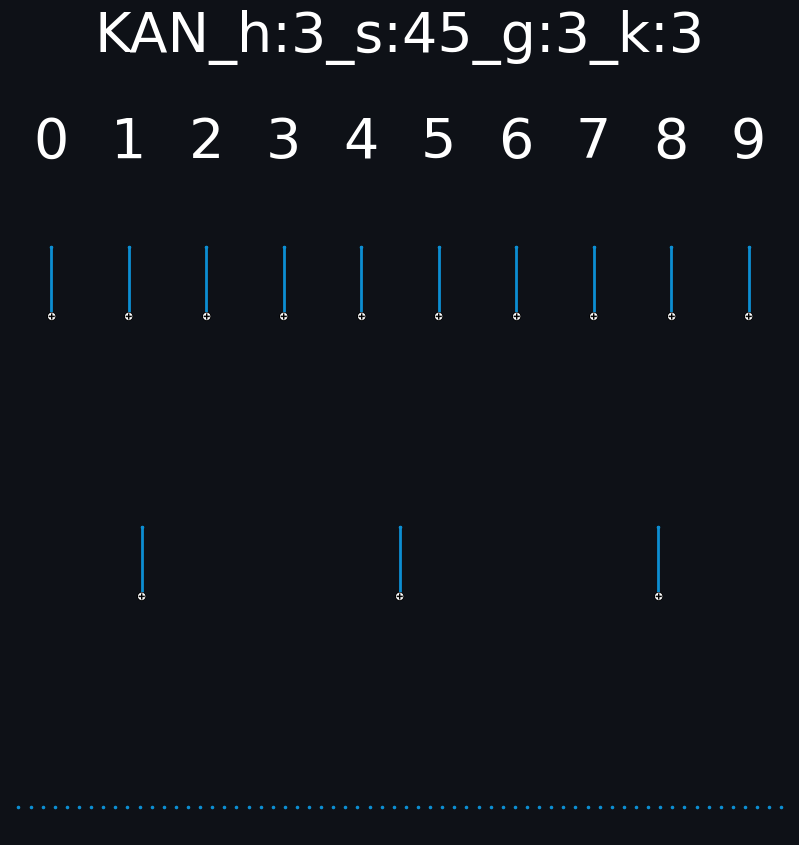

In [60]:
model.plot(beta=3, scale=1,folder="/pictures", out_vars=['0','1','2','3','4','5','6','7','8','9'], title = f"KAN_h:{hidden_1}_s:{steps}_g:{grid}_k:{k}",color_activations=act_dict_test,plus=0.5, ac_scale=1.2)